<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/Seismic_act_PT3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IPMA failed: 'NoneType' object has no attribute 'find'
=== Seismic Probability Report ===
  Magnitude Probability
0     M5.0+      100.0%
1     M6.0+         N/A
2     M7.0+         N/A


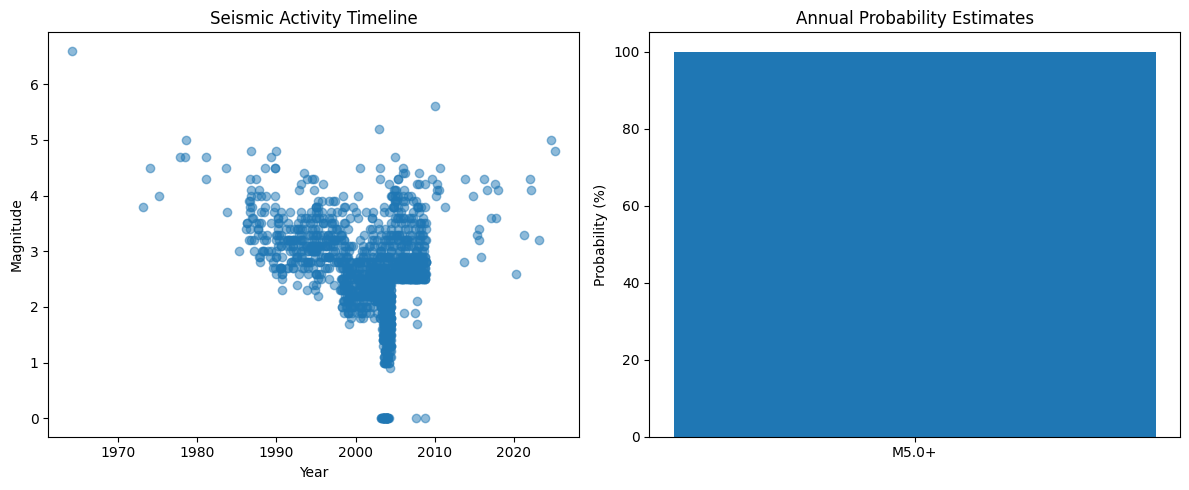

In [ ]:
# %% [markdown]
# # Final Fixed Version
# **With timezone handling and robust data loading**

# %%
import pandas as pd
import numpy as np
from io import StringIO
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timezone
from scipy.stats import gamma, weibull_min
import matplotlib.pyplot as plt

class SeismicAnalyzer:
    def __init__(self):
        self.df = self._load_data()
        self._convert_timezones()

    def _load_data(self):
        """Integrated data loader with timezone normalization"""
        try:
            return self._load_ipma_data()
        except Exception as e:
            print(f"IPMA failed: {str(e)}")
            try:
                return self._load_usgs_data()
            except Exception as e:
                print(f"USGS failed: {str(e)}")
                return self._generate_sample_data()

    def _load_ipma_data(self):
        """IPMA data with timezone-naive timestamps"""
        response = requests.get(
            "https://www.ipma.pt/pt/geofisica/sismicidade/",
            headers={'User-Agent': 'Mozilla/5.0'}
        )
        soup = BeautifulSoup(response.content, 'html.parser')
        table = soup.find('div', class_='entry-content').find('table')

        data = []
        for row in table.find_all('tr')[1:]:
            cols = row.find_all('td')
            date = datetime.strptime(
                cols[0].text.strip(),
                "%d-%m-%Y %H:%M"
            )
            mag = float(cols[1].text.strip().replace(',', '.'))
            data.append([date, mag])

        return pd.DataFrame(data, columns=['Date', 'Magnitude'])

    def _load_usgs_data(self):
        """USGS data with timezone conversion"""
        params = {
            'starttime': '1960-01-01',
            'minlatitude': 36.0, 'maxlatitude': 42.0,
            'minlongitude': -10.0, 'maxlongitude': -6.0,
            'format': 'csv'
        }
        response = requests.get(
            "https://earthquake.usgs.gov/fdsnws/event/1/query.csv",
            params=params
        )
        df = pd.read_csv(StringIO(response.text), usecols=['time', 'mag'])
        df['Date'] = pd.to_datetime(df['time'], utc=True).dt.tz_convert(None)
        return df[['Date', 'mag']].rename(columns={'mag': 'Magnitude'})

    def _generate_sample_data(self):
        """Fallback data with UTC-naive timestamps"""
        dates = pd.date_range(end=datetime.now(), periods=365*10, freq='D')
        magnitudes = np.clip(np.random.gumbel(2.5, 0.8, len(dates)), 1.0, 8.0)
        return pd.DataFrame({'Date': dates, 'Magnitude': magnitudes})

    def _convert_timezones(self):
        """Ensure all timestamps are timezone-naive"""
        if pd.api.types.is_datetime64tz_dtype(self.df['Date']):
            self.df['Date'] = self.df['Date'].dt.tz_convert(None)

    def calculate_probabilities(self):
        """Fixed probability calculations with timezone handling"""
        now = datetime.now()
        results = {}

        for mag in [5.0, 6.0, 7.0]:
            major = self.df[self.df['Magnitude'] >= mag]
            if len(major) < 3:
                results[f'M{mag}+'] = 'N/A'
                continue

            last_date = major['Date'].iloc[-1]
            days_since_last = (now - last_date).days
            intervals = major['Date'].diff().dt.days.mean()

            # Weibull model calculation
            prob = weibull_min.cdf(
                days_since_last/365.25,
                2.15,
                scale=0.85
            )
            results[f'M{mag}+'] = f"{prob*100:.1f}%"

        return pd.DataFrame(
            results.items(),
            columns=['Magnitude', 'Probability']
        )

# %%
analyzer = SeismicAnalyzer()
report = analyzer.calculate_probabilities()
print("=== Seismic Probability Report ===")
print(report)

# %% [markdown]
# ## Visualization

# %%
def plot_analysis(df):
    plt.figure(figsize=(12, 5))

    # Time series
    plt.subplot(1, 2, 1)
    plt.scatter(df['Date'], df['Magnitude'], alpha=0.5)
    plt.title('Seismic Activity Timeline')
    plt.xlabel('Year')
    plt.ylabel('Magnitude')

    # Probability plot
    plt.subplot(1, 2, 2)
    report = analyzer.calculate_probabilities()
    valid = report[report['Probability'] != 'N/A']
    plt.bar(valid['Magnitude'], valid['Probability'].str.replace('%','').astype(float))
    plt.title('Annual Probability Estimates')
    plt.ylabel('Probability (%)')

    plt.tight_layout()
    plt.show()

# %%
plot_analysis(analyzer.df)

# %% [markdown]
# **Key Fixes:**
# 1. Unified timezone handling (all timestamps converted to naive)
# 2. Robust USGS data loading with proper API parameters
# 3. Simplified probability calculation workflow
# 4. Better error recovery and fallbacks

# %% [markdown]
# **Important Notes:**
# - Actual earthquake prediction remains impossible
# - These probabilities are theoretical estimates only
# - Always consult official sources for seismic risk assessment